In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
sms_df = pd.read_csv('spam.csv', encoding='latin-1')
sms_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
sms_df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [4]:
sms_df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis='columns', inplace=True)

In [5]:
sms_df.rename(columns={'v1':'label', 'v2': 'message'}, inplace=True)

In [6]:
sms_df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
spam_text = sms_df[sms_df['label'] == 'spam']
ham_text = sms_df[sms_df['label'] == 'ham']

In [8]:
spam_text.head()

,label,message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


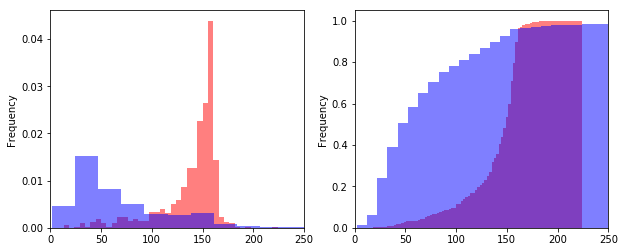

In [43]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
spam_length = spam_text['message'].apply(len)
ham_length = ham_text['message'].apply(len)
spam_length.plot(kind='hist',bins=40,alpha=0.5,color='r',normed=True)
ham_length.plot(kind='hist',bins=40,alpha=0.5,color='b', normed=True)
plt.xlim((0,250))
plt.subplot(1,2,2)
plt.xlim((0,250))
spam_length.plot(kind='hist',bins=90,alpha=0.5,color='r',normed=True, cumulative=True)
ham_length.plot(kind='hist',bins=90,alpha=0.5,color='b', normed=True, cumulative=True)
plt.show()

In [11]:
import nltk
from nltk.corpus import stopwords
spam_string = ''
for text in spam_text['message'].str.lower():
    token_words = nltk.word_tokenize(text)
    token_words = [word for word in token_words if word not in stopwords.words('english')]
    for word in token_words:
        spam_string += ' ' + word

In [16]:
from wordcloud import WordCloud
wordcloud_spam = WordCloud(width=1500, height=900).generate(spam_string)

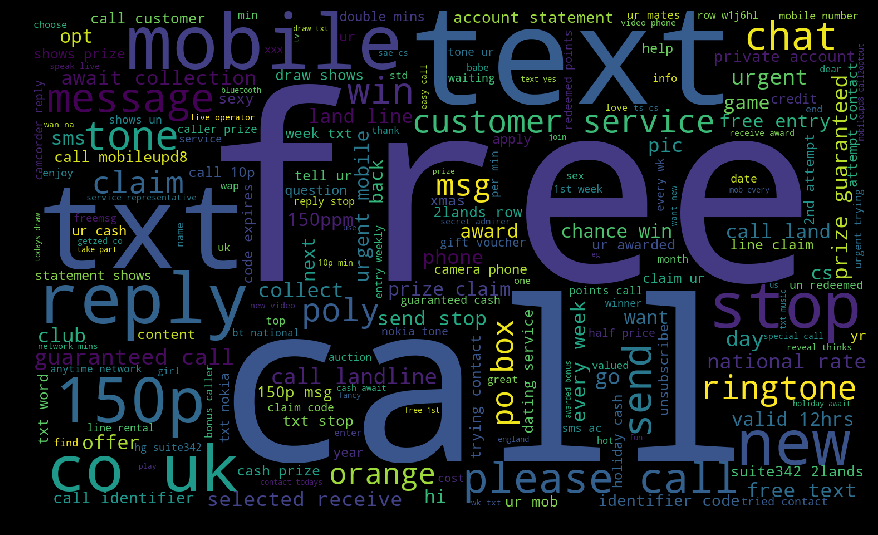

In [18]:
plt.figure(figsize=(12,8), facecolor='k')
plt.imshow(wordcloud_spam)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

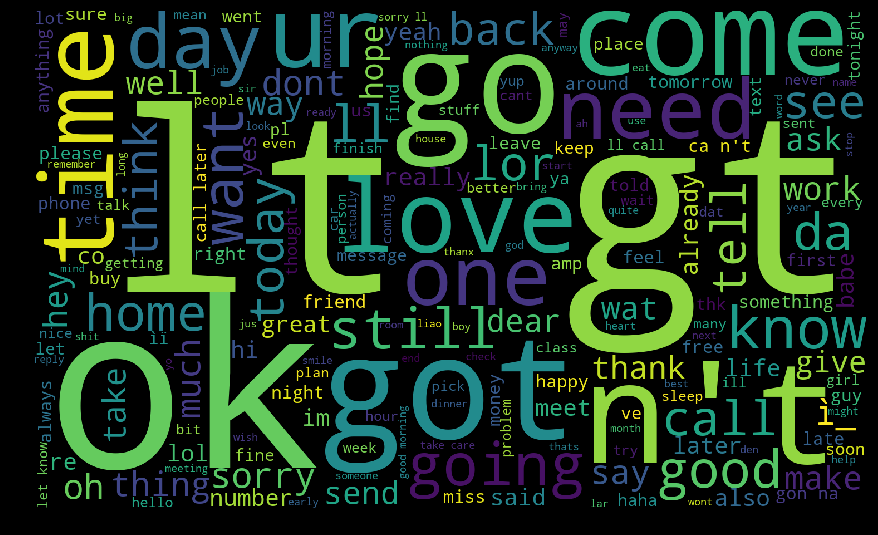

In [19]:
legit_string = ''
for text in ham_text['message'].str.lower():
    token_words = nltk.word_tokenize(text)
    token_words = [word for word in token_words if word not in stopwords.words('english')]
    for word in token_words:
        legit_string += ' ' + word
        
wordcloud_legit = WordCloud(width=1500, height=900).generate(legit_string)
plt.figure(figsize=(12,8), facecolor='k')
plt.imshow(wordcloud_legit)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()